<a href="https://colab.research.google.com/github/Lexi-Zhou/stats201-project-zzz/blob/main/Code/W4_3_Model2_LOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load data

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Define LOR function: Weighted Log Odds Ratio

In [4]:
# 2. Define LOR function: Weighted Log Odds Ratio

def compute_log_odds_zscore (group1_counts, group2_counts, prior_counts):
    """
    calculate z-score
    group1: female by default
    group2: male by default
    prior: Background Corpus
    """

    # calculate totals
    n1 = sum(group1_counts.values())
    n2 = sum(group2_counts.values())
    alpha0 = sum(prior_counts.values()) # total of background corpus

    vocab = set(group1_counts.keys()) | set(group2_counts.keys()) #??
    z_scores = {}

    for word in vocab:
      # Dirichlet Prior Smoothing
      alpha_w = prior_counts.get(word, 0) + 0.01

      # Log odds ration
      # log(f_w_group1 / f_w_group2)
      log_odds = (
          np.log((group1_counts[word] + alpha_w) / (n1 + alpha0 - group1_counts[word] - alpha_w)) -
          np.log((group2_counts[word] + alpha_w) / (n2 + alpha0 - group2_counts[word] - alpha_w))
      )

      # variance
      variance = 1 / (group1_counts[word] + alpha_w) + 1 / (group2_counts[word] + alpha_w)

      # z-score
      z_scores[word] = log_odds / np.sqrt(variance)

    return z_scores


# 3. Loop and process each df

## 3.1 prepare df

In [5]:
file_dict = {
    "STEM_Poor": "18_RMP_stem_poor.csv",
    "STEM_Avg": "18_RMP_stem_average.csv",
    "STEM_Good": "18_RMP_stem_good.csv",
    "Human_Poor": "18_RMP_humanities_poor.csv",
    "Human_Avg": "18_RMP_humanities_average.csv",
    "Human_Good": "18_RMP_humanities_good.csv"
}
base_path = "/content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_4/"

In [ ]:
# all_z_scores = [] # Moved to cell 4ExpKgFlzEtb to ensure reset on each run

## 3.2 run and analyze

In [6]:
print("--- Detailed Top 20 Lists ---")

all_formatted_outputs_str = [] # Initialize list to store formatted outputs
all_z_scores = [] # Initialize list to store Z-score dataframes for heatmaps

for label, filename in file_dict.items():
  df_raw = pd.read_csv(base_path + filename)

  for text_col in ['comments_original', 'comments_scrubbed']:

    # word frequency
    female_counts = Counter(" ".join(df_raw[df_raw['prof_gender_finalized'] == 'female'][text_col].astype(str)).split())
    male_counts = Counter(" ".join(df_raw[df_raw['prof_gender_finalized'] == 'male'][text_col].astype(str)).split())
    background_counts = female_counts + male_counts

    # z-scores
    z_scores = compute_log_odds_zscore(male_counts, female_counts, background_counts)

    # => dataframe
    res_df = pd.DataFrame(list(z_scores.items()), columns = ['Word', 'Z_Score'])

    # Add directional label
    res_df['Direction'] = res_df['Z_Score'].apply(lambda x: 'Female' if x < 0 else 'Male')

    # rank by effect size (Abs_Z)
    res_df['Abs_Z'] = res_df['Z_Score'].abs()

    # Top 20 words by effect size
    top_20 = res_df.sort_values(by='Abs_Z', ascending=False).head(20)

    # Prepare output for display and collection as requested by the user
    output_to_display = top_20[['Word', 'Z_Score', 'Direction']].reset_index(drop=True)

    current_output_buffer = []
    current_output_buffer.append(f"\n{'='*30}")
    current_output_buffer.append(f"SUBSET: {label}")
    current_output_buffer.append(f"COLUMN: {text_col}")
    current_output_buffer.append(f"{'='*30}")
    current_output_buffer.append(output_to_display.to_string(index=False))
    current_output_buffer_str = "\n".join(current_output_buffer)

    print(current_output_buffer_str) # Output to the text box
    all_formatted_outputs_str.append(current_output_buffer_str) # Collect for saving


    res_df_full = res_df[['Word', 'Z_Score']].set_index('Word')
    res_df_full.columns = [f"{label}_{text_col}"]
    all_z_scores.append(res_df_full)

--- Detailed Top 20 Lists ---

SUBSET: STEM_Poor
COLUMN: comments_original
      Word    Z_Score Direction
       she -18.786740    Female
        he  15.613160      Male
       her -13.510725    Female
       his   9.148334      Male
       him   6.744626      Male
       guy   4.609687      Male
       man   2.503701      Male
      shes  -2.377591    Female
      lady  -2.377591    Female
  clinical  -2.186832    Female
    carson  -2.186832    Female
       lab   2.173313      Male
 chemistry   1.981371      Male
recitation  -1.973989    Female
   narcisa  -1.864587    Female
        su   1.769136      Male
       not  -1.748310    Female
    claire  -1.744029    Female
       way  -1.728802    Female
      time  -1.666304    Female

SUBSET: STEM_Poor
COLUMN: comments_scrubbed
       Word   Z_Score Direction
   clinical -2.187723    Female
     carson -2.187723    Female
        lab  2.172084      Male
  chemistry  1.980510      Male
 recitation -1.974929    Female
    narcisa -1.8

In [7]:
output_file_path = os.path.join(base_path, "20_LOR_combined_top_20_words_analysis.txt")

with open(output_file_path, 'w', encoding='utf-8') as f:
    for output_str in all_formatted_outputs_str:
        f.write(output_str + "\n")

print(f"All formatted outputs saved to: {output_file_path}")

All formatted outputs saved to: /content/drive/MyDrive/Colab Notebooks/stats201_final_project/Week_4/20_LOR_combined_top_20_words_analysis.txt


## 3.3 heatmap

### 3.3.1 STEM vs Humanities (original + scrubbed)

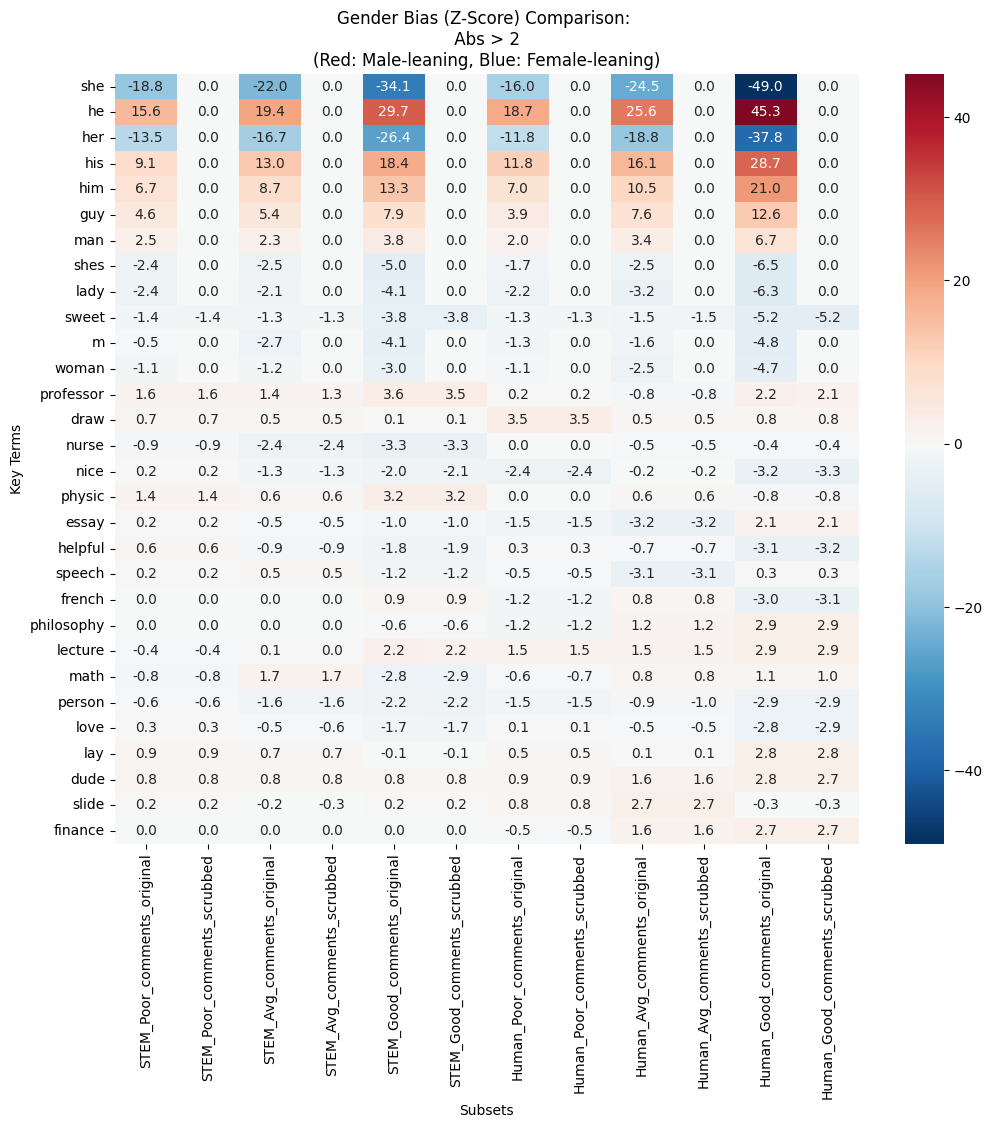

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.concat(all_z_scores, axis=1).fillna(0)

# Filter for words where Abs(Z) > 2 in at least one column, then select the top 30 by largest max Abs(Z)
interesting_words = combined_df.loc[combined_df.abs().max(axis=1) > 2].abs().max(axis=1).nlargest(30).index
heatmap_data = combined_df.loc[interesting_words]

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="RdBu_r", center=0, annot=True, fmt=".1f")
plt.title("Gender Bias (Z-Score) Comparison: \n Abs > 2 \n(Red: Male-leaning, Blue: Female-leaning)")
plt.xlabel("Subsets")
plt.ylabel("Key Terms")
plt.show()

### 3.3.2 STEM vs Humanities (only scrubbed)

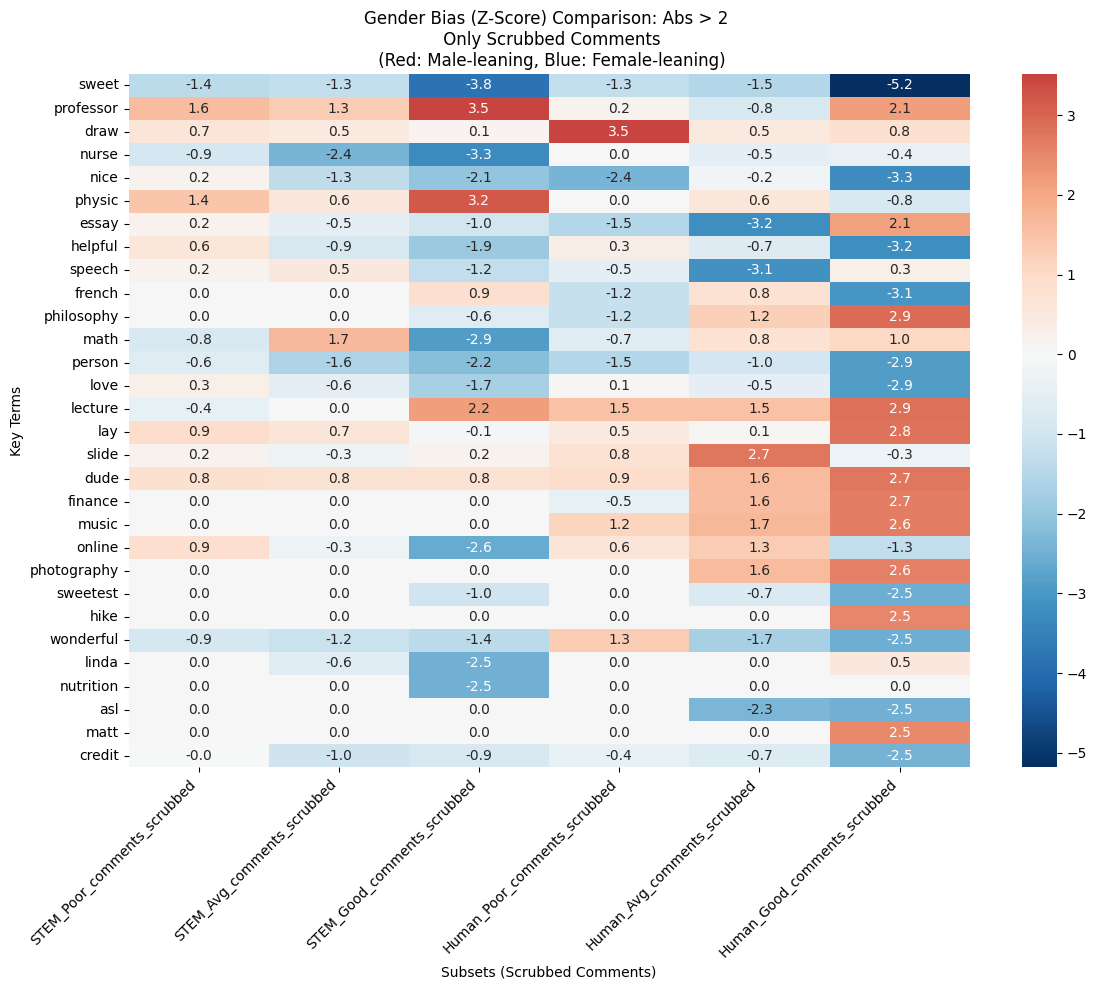

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter combined_df to only include 'comments_scrubbed' columns
scrubbed_cols = [col for col in combined_df.columns if 'comments_scrubbed' in col]
combined_df_scrubbed = combined_df[scrubbed_cols]

# Determine interesting words based on Z-scores in scrubbed comments
# Filter for words where Abs(Z) > 2 in at least one scrubbed column, then select the top 30 by largest max Abs(Z)
interesting_words_scrubbed = combined_df_scrubbed.loc[combined_df_scrubbed.abs().max(axis=1) > 2].abs().max(axis=1).nlargest(30).index

# Prepare heatmap data for these significant words in scrubbed comments
heatmap_data_scrubbed = combined_df_scrubbed.loc[interesting_words_scrubbed]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data_scrubbed, cmap="RdBu_r", center=0, annot=True, fmt=".1f")
plt.title("Gender Bias (Z-Score) Comparison: Abs > 2 \n Only Scrubbed Comments\n (Red: Male-leaning, Blue: Female-leaning)")
plt.xlabel("Subsets (Scrubbed Comments)")
plt.ylabel("Key Terms")
plt.xticks(rotation=45, ha='right') # Rotate column labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()